In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers==4.52.4 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 144.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 97.9 MB/s eta 0:00:00


In [3]:
!pip install datasets==3.6.0 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 31.2 MB/s eta 0:00:00


In [4]:
!pip install pysentimiento -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 49.0 MB/s eta 0:00:00


In [5]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from pysentimiento.preprocessing import preprocess_tweet

from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score,accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf

In [6]:
# Preprocess data function to create TensorFlow datasets
def preprocess_data(split_df,num_labels):
# Tokenize the texts and set maximum length, truncation and padding size
  texts = split_df['text'].tolist()
  encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=64,return_token_type_ids=False)

# Convert the labels to one-hot encoding
  labels = split_df['label'].tolist()
  labels_encoded = tf.one_hot(labels, num_labels)

# Create TensorFlow datasets
  dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels_encoded))

  return dataset

# Pre-train

Use a model with a high confidence labeling dataset

In [7]:
# Initialize classification model
classification_model = TFAutoModelForSequenceClassification.from_pretrained(
    "pysentimiento/robertuito-base-uncased",
    num_labels=2,
    output_attentions=True,
    ignore_mismatched_sizes=True  # Required for architecture change
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("pysentimiento/robertuito-base-uncased")
tokenizer.model_max_length = 64

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/323 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [8]:
# Print the model summary
classification_model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  108196608 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  592130    
 ificationHead)                                                  
                                                                 
Total params: 108788738 (415.00 MB)
Trainable params: 108788738 (415.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Set the layers to be trainable
classification_model.get_layer('roberta').trainable = True
classification_model.get_layer('classifier').trainable = True

## read cardiff data


https://huggingface.co/datasets/cardiffnlp/tweet_sentiment_multilingual

In [10]:
# negative = 0
# neutral = 1
# postive = 2

# read cardiff data with spanish tweets
ds = load_dataset("cardiffnlp/tweet_sentiment_multilingual", "spanish")

README.md: 0.00B [00:00, ?B/s]

tweet_sentiment_multilingual.py: 0.00B [00:00, ?B/s]

0000.parquet:   0%|          | 0.00/120k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/58.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1839 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/324 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/870 [00:00<?, ? examples/s]

In [11]:
# merge train, test and validation neutral samples from ds format
df_cardiff = pd.concat([pd.DataFrame(ds['train']), pd.DataFrame(ds['test']), pd.DataFrame(ds['validation'])])

In [12]:
# convert to pandas nullable string
df_cardiff['text'] = df_cardiff['text'].astype(str)

# Drop rows with empty texts
df_cardiff = df_cardiff.dropna(subset=['text'])

# Drop duplicate texts
df_cardiff = df_cardiff.drop_duplicates(subset=['text'])

# Reset the index
df_cardiff = df_cardiff.reset_index(drop=True)

# Lowercase the texts
df_cardiff['text'] = df_cardiff['text'].str.lower()

# remove irregular spacing
df_cardiff['text'] = df_cardiff['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Remove tokens that contain backslashes
df_cardiff['text'] = df_cardiff['text'].str.replace(r'\S*\\\S*', '', regex=True)

# Add space before 'http' if there isn't
df_cardiff['text'] = df_cardiff['text'].str.replace(r'(?<!\s)(http)', r' \1', regex=True)

# Preprocess the texts using the preprocess_tweet function
df_cardiff['text'] = df_cardiff['text'].apply(lambda x:preprocess_tweet(x))

# remove multiple consecutive occurrences of '@usuario'
df_cardiff['text'] = df_cardiff['text'].str.replace(r'(@usuario\s*)+', '@usuario ', regex=True)
df_cardiff['text'] = df_cardiff['text'].str.replace(r'(@user\s*)+', '@usuario', regex=True)

# remove multiple consecutive occurrences of url
df_cardiff['text'] = df_cardiff['text'].str.replace(r'(url\s*)+', 'url ', regex=True)

# remove irregular spacing
df_cardiff['text'] = df_cardiff['text'].str.replace(' +', ' ', regex=True)


In [13]:
# convert neutral (original label 1) to non-hate (0)
df_neutral = df_cardiff.loc[df_cardiff['label']==1]
df_neutral.loc[df_neutral['label']==1,'label'] = 0

# use only 200 neutral tweets
df_neutral = df_neutral.reset_index(drop=True)
df_neutral = df_neutral.sample(n=200, random_state=42)

In [14]:
# remove neutral tweets
df_on = df_cardiff.loc[df_cardiff['label']!=1]

# convert negative (original label 0) to hate (1) and positive (original label 2) to non-hate (0)
df_on['label'] = df_on['label'].replace({0: 1,2:0})

/tmp/ipython-input-1502650387.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_on['label'] = df_on['label'].replace({0: 1,2:0})


In [15]:
# merge
df_on = pd.concat([df_on,df_neutral])
df_on = df_on.reset_index(drop=True)

# lowercase text
df_on['text'] = df_on['text'].str.lower()

In [16]:
# print unique labels
len(df_on['label'].unique())

2

In [17]:
# Split your DataFrame
train_df, temp_df = train_test_split(df_on, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# convert to tensorflow, tokenize and create datasets in trainable format
num_labels = len(df_on['label'].unique())
train_dataset = preprocess_data(train_df,num_labels)
test_dataset = preprocess_data(test_df,num_labels)
val_dataset = preprocess_data(val_df,num_labels)


## set the model

Re-define the model architecture: use `input_ids` and `attention_mask` as inputs to dense layer

In [18]:
# set input ids as input
input_ids = tf.keras.layers.Input(shape=(64,), dtype=tf.int32, name='input_ids')

# set attention mask as input
attention_mask = tf.keras.layers.Input(shape=(64,), dtype=tf.int32, name='attention_mask')

# modify the model
output = classification_model(input_ids, attention_mask=attention_mask)[0]
output = tf.keras.layers.Dense(num_labels)(output[:, :])

# set the model to its final form
classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)


In [19]:
# create a warmup schedule
class WarmupLinearSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, max_lr=2e-5):
        super().__init__()
        # cast warmup_steps and max_lr to float to tensorflow format
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
        self.max_lr = max_lr

    def __call__(self, step):
        # cast step to tensorflow format
        step = tf.cast(step, tf.float32)
        # Linear warmup
        lr = self.max_lr * (step / self.warmup_steps)
        # After warmup, keep constant LR
        return tf.minimum(lr, self.max_lr)

# Calculate training parameters
batch_size = 128
epochs = 5

# calcualte steps
steps_per_epoch = len(train_df) // batch_size
total_steps = steps_per_epoch * epochs

# set warmup steps
warmup_steps = int(0.1 * total_steps)  # 10% warmup

#print("total_steps:",total_steps,"- warmup_steps:",warmup_steps)
total_steps,warmup_steps

(65, 6)

In [20]:
# Initialize optimizer CORRECTLY
optimizer = tf.keras.optimizers.Adam(
    learning_rate=WarmupLinearSchedule(
        warmup_steps=warmup_steps,
        max_lr=2e-5))

# Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    patience=2,
    verbose=1)

# Compile model
classification_model.compile(
    optimizer=optimizer,  # Pass the optimizer instance directly
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.Recall(name='recall', class_id=1), # Focus on hate class
             tf.keras.metrics.Precision(name='precision', class_id=1), # Focus on hate class
             tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'), # Focus on hate class
             tf.keras.metrics.F1Score(name="f1_score", average='weighted'), # Use weighted average for f1_score
             tf.keras.metrics.AUC(name='AUC', curve='PR'),
             tf.keras.metrics.RecallAtPrecision(precision=0.6, name='recall_at_precision', class_id=1), # Focus on hate class
             tf.keras.metrics.PrecisionAtRecall(recall=0.6,name='precision_at_recall', class_id=1)]) # Focus on hate class

# Train model
history = classification_model.fit(
    train_dataset.batch(batch_size),
    validation_data=val_dataset.batch(batch_size),
    callbacks=callback,
    epochs=epochs)
#14/14 [==============================] - 9s 641ms/step - loss: 0.1380 - accuracy: 0.9550 - val_loss: 0.2716 - val_accuracy: 0.9009

Epoch 1/5
14/14 [==============================] - 65s 734ms/step - loss: 0.6433 - recall: 0.0062 - precision: 1.0000 - binary_accuracy: 0.5014 - f1_score: 0.6305 - AUC: 0.6549 - recall_at_precision: 0.4957 - precision_at_recall: 0.0000e+00 - val_loss: 0.5440 - val_recall: 0.0476 - val_precision: 1.0000 - val_binary_accuracy: 0.5113 - val_f1_score: 0.7774 - val_AUC: 0.8486 - val_recall_at_precision: 0.5714 - val_precision_at_recall: 0.0000e+00
Epoch 2/5
14/14 [==============================] - 3s 182ms/step - loss: 0.4782 - recall: 0.3137 - precision: 0.9273 - binary_accuracy: 0.5909 - f1_score: 0.8250 - AUC: 0.8590 - recall_at_precision: 0.7651 - precision_at_recall: 0.8921 - val_loss: 0.3779 - val_recall: 0.6786 - val_precision: 0.8769 - val_binary_accuracy: 0.7185 - val_f1_score: 0.8621 - val_AUC: 0.8904 - val_recall_at_precision: 0.9048 - val_precision_at_recall: 0.9107
Epoch 3/5
14/14 [==============================] - 3s 188ms/step - loss: 0.3160 - recall: 0.7761 - precision: 0.9

## Pre-training results

In [21]:
# make predictions
predictions = classification_model.predict(test_dataset.batch(batch_size))

2/2 [==============================] - 3s 53ms/step


In [22]:
# Get true labels from test_ds and convert to one-hot encoding
y_true = test_df['label']

# Get predictions from your model
y_pred = tf.argmax(predictions, axis=1)  # predictions[0] contains probabilities/logits

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred) # or use y_pred_classes if calculated above

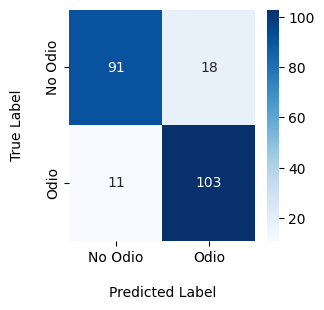

In [23]:
# plot confusion matrix
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Odio', 'Odio'],
            yticklabels=['No Odio', 'Odio'])
plt.xlabel("\nPredicted Label")
plt.ylabel("True Label\n")
plt.show()

In [ ]:
# to get probabilities
#y_pred_prob = tf.nn.softmax(predictions[0], axis=-1).numpy()

In [24]:
# Calculate metrics
metrics = {
    "Recall (Macro)": recall_score(y_true, y_pred, average='macro'),
    "Precision (Macro)": precision_score(y_true, y_pred, average='macro'),
    "F1 (Macro)": f1_score(y_true, y_pred, average='macro'),
    "AUC (OvR)": roc_auc_score(y_true, y_pred, multi_class='ovr'),  # One-vs-Rest AUC
    "Accuracy": accuracy_score(y_true, y_pred)
}

# For per-class metrics
per_class_metrics = {
    "Recall (Per Class)": recall_score(y_true, y_pred, average=None),
    "Precision (Per Class)": precision_score(y_true, y_pred, average=None),
    "F1 (Per Class)": f1_score(y_true, y_pred, average=None)
}

# Print results
print("Aggregate Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

print("\nPer-Class Metrics:")
for i, (rec, prec, f1) in enumerate(zip(per_class_metrics["Recall (Per Class)"],
                                      per_class_metrics["Precision (Per Class)"],
                                      per_class_metrics["F1 (Per Class)"])):
    print(f"Class {i}: Recall={rec:.4f}, Precision={prec:.4f}, F1={f1:.4f}")

print(classification_report(y_true, y_pred))

Aggregate Metrics:
Recall (Macro): 0.8692
Precision (Macro): 0.8717
F1 (Macro): 0.8696
AUC (OvR): 0.8692
Accuracy: 0.8700

Per-Class Metrics:
Class 0: Recall=0.8349, Precision=0.8922, F1=0.8626
Class 1: Recall=0.9035, Precision=0.8512, F1=0.8766
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       109
           1       0.85      0.90      0.88       114

    accuracy                           0.87       223
   macro avg       0.87      0.87      0.87       223
weighted avg       0.87      0.87      0.87       223



In [ ]:
# # save model weights
# classification_model.save_weights("/content/drive/MyDrive/HateMedia/V2/cardiff_data.h5")

# # save tokenizer
# tokenizer.save_pretrained("/content/drive/MyDrive/HateMedia/V2/cardiff_data_tokenizer")

# Train Hatemedia Data

## Read data

In [25]:
# load data
df_on = pd.read_csv('/content/df_odio_final.csv',dtype={'text':str,'ODIO':str})
df_on.head()

,text,ODIO,TIPO DE ODIO,INTENSIDAD DE ODIO,lang_confidence,transformed
0,!que cuadrilla de jetas y caraduras que compon...,1,2.0,3.0,0.942327,False
1,"""arrodear"" el congreso es cosa de izquierdas y...",1,1.0,1.0,0.999715,False
2,"""okupa, barcelona, agresión"" todo me cuadra",1,2.0,1.0,0.875567,False
3,"""periodistas"" = traidores terroristas colabora...",1,2.0,3.0,0.951864,False
4,"""periodistas"", dejen de esconder y alentar las...",1,4.0,1.0,0.989946,False


In [26]:
for val,label in zip(df_on['text'].values,df_on['ODIO']):
  if ('maldito' in val) and (label=='0'):
    print(val,label)

5 así ha dicho jehová:maldito el varón que confía en el hombre,y pone carne por su brazo,y su corazón se aparta de jehová 0
la culpa de franco, maldito facha. 0
puñetero aeropuerto ; la de miles y miles de contagiados que llegan a madrid por el aeropuerto. seguro que los malditos europeos nos los mandan , para cabrear a ayuso. 0
malditos delincuentes, espero que la guardia civil haya hecho su trabajo, yo aquí encerrado y ellos ahí colapsando las ucis, irresponsables! xddd ¿hasta dónde hemos llegado? 0
sois unos malditos terroristas informativos. deberíais de estar en la cárcel. 0
la variante británica está bien ... si digo virus chino soy un maldito ... que cosas no ..? 0
que os den,llevaba un crucifijo, y?es pecado?homenaje que este maldito gobierno nos quiere hacer olvidar,a todos los que nos han dejado,como las víctimas del terrorismo,demagogos,asco de país con tanto gilipollas renegado 0
si. seguiremos en esta mierda por 5 años más .. que chingada estos comunistas. ahhh ... y si la

In [27]:
# leave only needed cols
df_on = df_on.rename(columns={'ODIO':'label'})
df_on = df_on[['text','label']]
df_on.head()

,text,label
0,!que cuadrilla de jetas y caraduras que compon...,1
1,"""arrodear"" el congreso es cosa de izquierdas y...",1
2,"""okupa, barcelona, agresión"" todo me cuadra",1
3,"""periodistas"" = traidores terroristas colabora...",1
4,"""periodistas"", dejen de esconder y alentar las...",1


In [28]:
# see class distribution
df_on['label'].value_counts()

,count
label,
0,88644
1,39454


In [29]:
print(df_on.loc[df_on['label'].isna()==True])
df_on.loc[df_on['label'].isna()==True] = '1'

Empty DataFrame
Columns: [text, label]
Index: []


In [30]:
# Split your DataFrame
train_df, temp_df = train_test_split(df_on, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# convert label column to integer type
train_df['label'] = train_df['label'].astype(int)
test_df['label'] = test_df['label'].astype(int)
val_df['label'] = val_df['label'].astype(int)

# convert to tensorflow, tokenize and create datasets in trainable format
num_labels = len(df_on['label'].unique())
train_dataset = preprocess_data(train_df,num_labels)
test_dataset = preprocess_data(test_df,num_labels)
val_dataset = preprocess_data(val_df,num_labels)

In [31]:
print("train_df:",len(train_df),"test_df:",len(test_df),"val_df:",len(val_df))

train_df: 102478 test_df: 12810 val_df: 12810


## Train

In [32]:
# make a copy
classification_model_hatemedia = classification_model

In [33]:
# Calculate training parameters
batch_size = 128
epochs = 10
steps_per_epoch = len(train_df) // batch_size
total_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * total_steps)  # 10% warmup
print("total_steps",total_steps,"warmup_steps",warmup_steps)

# Initialize optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=WarmupLinearSchedule(
        warmup_steps=warmup_steps,
        max_lr=2e-5))

# Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision',
    mode='max',
    restore_best_weights=True,
    patience=4,
    verbose=1)

total_steps 8000 warmup_steps 800


In [34]:
# Compile model
classification_model_hatemedia.compile(
    optimizer=optimizer,  # Pass the optimizer instance directly
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.Recall(name='recall', class_id=1), # Focus on hate class
             tf.keras.metrics.Precision(name='precision', class_id=1), # Focus on hate class
             tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'), # Focus on hate class
             tf.keras.metrics.F1Score(name="f1_score", average='weighted'), # Use weighted average for f1_score
             tf.keras.metrics.AUC(name='AUC', curve='PR')]) # Focus on hate class

# Train model
history = classification_model_hatemedia.fit(
    train_dataset.batch(batch_size),
    validation_data=val_dataset.batch(batch_size),
    callbacks=callback,
    batch_size=batch_size,
    epochs=epochs)

Epoch 1/10
801/801 [==============================] - 228s 218ms/step - loss: 0.6024 - recall: 0.3499 - precision: 0.5790 - binary_accuracy: 0.6506 - f1_score: 0.7284 - AUC: 0.7081 - val_loss: 0.4029 - val_recall: 0.3919 - val_precision: 0.8541 - val_binary_accuracy: 0.7706 - val_f1_score: 0.8067 - val_AUC: 0.8726
Epoch 2/10
801/801 [==============================] - 126s 158ms/step - loss: 0.3717 - recall: 0.5155 - precision: 0.8440 - binary_accuracy: 0.7774 - f1_score: 0.8292 - AUC: 0.8792 - val_loss: 0.3512 - val_recall: 0.5382 - val_precision: 0.8619 - val_binary_accuracy: 0.8090 - val_f1_score: 0.8399 - val_AUC: 0.8910
Epoch 3/10
801/801 [==============================] - 126s 157ms/step - loss: 0.2860 - recall: 0.6571 - precision: 0.8864 - binary_accuracy: 0.8393 - f1_score: 0.8760 - AUC: 0.9179 - val_loss: 0.3570 - val_recall: 0.6265 - val_precision: 0.8320 - val_binary_accuracy: 0.8264 - val_f1_score: 0.8488 - val_AUC: 0.8844
Epoch 4/10
801/801 [==============================] 

In [35]:
# Compute class weights based on the number of samples of each class.
# class weights will be given by n_samples / (n_classes * np.bincount(y))

class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(train_df['label']), y=train_df['label'])
class_weight = np.round(class_weight,2).tolist()
class_weight = {i: class_weight[i] for i in range(len(class_weight))}
class_weight

{0: 0.72, 1: 1.62}

In [37]:
# Calculate training parameters
batch_size = 128
epochs = 5
steps_per_epoch = len(train_df) // batch_size
total_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * total_steps)  # 10% warmup
print("total_steps",total_steps,"warmup_steps",warmup_steps)

# Initialize optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=WarmupLinearSchedule(
        warmup_steps=warmup_steps,
        max_lr=2e-5))

# Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_recall',
    mode='max',
    restore_best_weights=True,
    patience=2,
    verbose=1)

total_steps 4000 warmup_steps 400


In [39]:
# Compile model
classification_model_hatemedia.compile(
    optimizer=optimizer,  # Pass the optimizer instance directly
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.Recall(name='recall', class_id=1), # Focus on hate class
             tf.keras.metrics.Precision(name='precision', class_id=1), # Focus on hate class
             tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'), # Focus on hate class
             tf.keras.metrics.F1Score(name="f1_score", average='weighted'), # Use weighted average for f1_score
             tf.keras.metrics.AUC(name='AUC', curve='PR')]) # Focus on hate class

# Train model
history = classification_model_hatemedia.fit(
    train_dataset.batch(batch_size),
    validation_data=val_dataset.batch(batch_size),
    class_weight=class_weight,
    callbacks=callback,
    batch_size=batch_size,
    epochs=epochs)

Epoch 1/5
801/801 [==============================] - 224s 216ms/step - loss: 0.1000 - recall: 0.9363 - precision: 0.9475 - binary_accuracy: 0.9484 - f1_score: 0.9624 - AUC: 0.9747 - val_loss: 0.5457 - val_recall: 0.6903 - val_precision: 0.7905 - val_binary_accuracy: 0.8392 - val_f1_score: 0.8466 - val_AUC: 0.8540
Epoch 2/5
801/801 [==============================] - 126s 158ms/step - loss: 0.0753 - recall: 0.9578 - precision: 0.9550 - binary_accuracy: 0.9612 - f1_score: 0.9714 - AUC: 0.9803 - val_loss: 0.6269 - val_recall: 0.7321 - val_precision: 0.7652 - val_binary_accuracy: 0.8385 - val_f1_score: 0.8447 - val_AUC: 0.8435
Epoch 3/5
801/801 [==============================] - 126s 157ms/step - loss: 0.0578 - recall: 0.9688 - precision: 0.9660 - binary_accuracy: 0.9708 - f1_score: 0.9784 - AUC: 0.9847 - val_loss: 0.6754 - val_recall: 0.7522 - val_precision: 0.7429 - val_binary_accuracy: 0.8335 - val_f1_score: 0.8405 - val_AUC: 0.8336
Epoch 4/5
801/801 [==============================] - 12

In [40]:
# Compile model
classification_model_hatemedia.compile(
    optimizer=optimizer,  # Pass the optimizer instance directly
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.Recall(name='recall', class_id=1), # Focus on hate class
             tf.keras.metrics.Precision(name='precision', class_id=1), # Focus on hate class
             tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'), # Focus on hate class
             tf.keras.metrics.F1Score(name="f1_score", average='weighted'), # Use weighted average for f1_score
             tf.keras.metrics.AUC(name='AUC', curve='PR')]) # Focus on hate class

# Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_score',
    mode='max',
    restore_best_weights=True,
    patience=2,
    verbose=1)

# Train model
history = classification_model_hatemedia.fit(
    train_dataset.batch(batch_size),
    validation_data=val_dataset.batch(batch_size),
    class_weight=class_weight,
    callbacks=callback,
    batch_size=batch_size,
    epochs=5)

Epoch 1/5
801/801 [==============================] - 147s 162ms/step - loss: 0.0313 - recall: 0.9839 - precision: 0.9816 - binary_accuracy: 0.9848 - f1_score: 0.9885 - AUC: 0.9919 - val_loss: 0.8742 - val_recall: 0.8003 - val_precision: 0.7056 - val_binary_accuracy: 0.8259 - val_f1_score: 0.8335 - val_AUC: 0.8151
Epoch 2/5
801/801 [==============================] - 126s 157ms/step - loss: 0.0244 - recall: 0.9879 - precision: 0.9850 - binary_accuracy: 0.9884 - f1_score: 0.9911 - AUC: 0.9936 - val_loss: 0.8813 - val_recall: 0.7969 - val_precision: 0.7021 - val_binary_accuracy: 0.8250 - val_f1_score: 0.8319 - val_AUC: 0.8152
Epoch 3/5
801/801 [==============================] - 126s 158ms/step - loss: 0.0224 - recall: 0.9888 - precision: 0.9864 - binary_accuracy: 0.9894 - f1_score: 0.9917 - AUC: 0.9942 - val_loss: 0.8155 - val_recall: 0.7814 - val_precision: 0.7265 - val_binary_accuracy: 0.8342 - val_f1_score: 0.8418 - val_AUC: 0.8263
Epoch 4/5
801/801 [==============================] - 12

# Results

In [41]:
# make predictions
predictions = classification_model_hatemedia.predict(test_dataset.batch(batch_size))

101/101 [==============================] - 9s 55ms/step


In [42]:
# Get true labels from test_df
y_true = test_df['label']

# Get predictions from your model
y_pred = tf.argmax(predictions, axis=1)  # predictions contains probabilities/logits

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

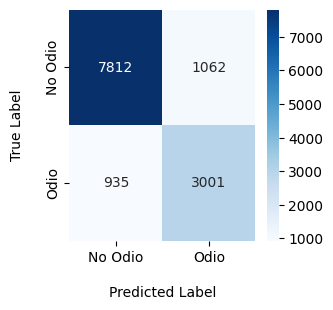

In [44]:
# plot confusion matrix
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Odio', 'Odio'],
            yticklabels=['No Odio', 'Odio'])
plt.xlabel("\nPredicted Label")
plt.ylabel("True Label\n")
plt.show()

In [45]:
# Calculate metrics
metrics = {
    "Recall (Macro)": recall_score(y_true, y_pred, average='macro'),
    "Precision (Macro)": precision_score(y_true, y_pred, average='macro'),
    "F1 (Macro)": f1_score(y_true, y_pred, average='macro'),
    "AUC (OvR)": roc_auc_score(y_true, y_pred, multi_class='ovr'),  # One-vs-Rest AUC
    "Accuracy": accuracy_score(y_true, y_pred)
}

# For per-class metrics
per_class_metrics = {
    "Recall (Per Class)": recall_score(y_true, y_pred, average=None),
    "Precision (Per Class)": precision_score(y_true, y_pred, average=None),
    "F1 (Per Class)": f1_score(y_true, y_pred, average=None)
}

# Print results
print("Aggregate Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

print("\nPer-Class Metrics:")
for i, (rec, prec, f1) in enumerate(zip(per_class_metrics["Recall (Per Class)"],
                                      per_class_metrics["Precision (Per Class)"],
                                      per_class_metrics["F1 (Per Class)"])):
    print(f"Class {i}: Recall={rec:.4f}, Precision={prec:.4f}, F1={f1:.4f}")

print(classification_report(y_true, y_pred))

Aggregate Metrics:
Recall (Macro): 0.8214
Precision (Macro): 0.8159
F1 (Macro): 0.8185
AUC (OvR): 0.8214
Accuracy: 0.8441

Per-Class Metrics:
Class 0: Recall=0.8803, Precision=0.8931, F1=0.8867
Class 1: Recall=0.7624, Precision=0.7386, F1=0.7503
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      8874
           1       0.74      0.76      0.75      3936

    accuracy                           0.84     12810
   macro avg       0.82      0.82      0.82     12810
weighted avg       0.85      0.84      0.84     12810



# Save the model

In [46]:
# Print the model summary
classification_model_hatemedia.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1087887   ['input_ids[0][0]',           
 assification (TFRobertaFor  (loss=None, logits=(None,    38         'attention_mask[0][0]']      
 SequenceClassification)     2),                                                              

In [47]:
# save model weights
classification_model_hatemedia.save_weights("/content/drive/MyDrive/HateMedia/V2/odio_no_odio.h5")

# save tokenizer
tokenizer.save_pretrained("/content/drive/MyDrive/HateMedia/V2/odio_no_odio_tokenizer")

('/content/drive/MyDrive/HateMedia/V2/odio_no_odio_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/HateMedia/V2/odio_no_odio_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/HateMedia/V2/odio_no_odio_tokenizer/tokenizer.json')

# requirements

In [48]:
# save requirements as a txt file
!pip freeze > requirements.txt

In [49]:
reqs = pd.read_csv('/content/requirements.txt',header=None)
reqs.to_csv('/content/drive/MyDrive/HateMedia/V2/odio_no_odio_requirements.csv')

In [ ]:
reqs

,0
0,absl-py==1.4.0
1,absolufy-imports==0.3.1
2,accelerate==1.11.0
3,aiofiles==24.1.0
4,aiohappyeyeballs==2.6.1
...,...
675,yellowbrick==1.5
676,yfinance==0.2.66
677,zict==3.0.0
678,zipp==3.23.0


In [50]:
from google.colab import runtime
runtime.unassign()